In [121]:
from gurobipy import *
import numpy as np
import math as mt


In [122]:
def random_matrice_utilite(n, p):
        return np.random.randint(50 ,size=(n,p))

def random_cout_projet(p):
        return np.random.randint(200 ,size=(p))

def generate_w_prime(n):
        # vecteur w
        w=[i for i in range(n,0,-1)]

        # creer le vecteur w'
        w_prime = [(w[k] - w[k+1]) for k in range(len(w)-1)]
        w_prime.append(w[-1])
        return w_prime

def generate_contrainte_matrice(n, p, u, couts_projet):
        ## les variables rk
        coef_rk = []
        for k in range(n):
                for i in range(n):
                        coef_rk.append([])
                        for j in range(n):
                                coef_rk[-1].append(0)
                        coef_rk[-1][k] = 1
        coef_rk = np.array(coef_rk)
        ## les variables bik
        coef_bik = -1 * np.identity(n**2)
        ## les variables x
        coef_xi = []
        for k in range(n**2):
                coef_xi.append([])
                for i in range(p):
                        coef_xi[-1].append(-u[k%n][i])
        coef_xi = np.array(coef_xi)
        # contrainte sur le budget
        budget = [0 for i in range(n*(n+1))]
        budget += [couts_projet[i] for i in range(p)]
        budget = np.array(budget)
        # concatenation des matrices rk, bik, xk 
        result_concat = np.concatenate(
                (coef_rk, np.concatenate((coef_bik, coef_xi),axis=1)),
                axis=1)

        # ajout de la contrainte sur les budgets
        constrainte = np.vstack([result_concat, budget])
        return constrainte
def second_membre_contraintes(n, budget_limit):
        second_membre = [0 for _ in range(n**2)]
        second_membre.append(budget_limit)
        second_membre = np.array(second_membre)
        return second_membre

def coef_func_objectif(w_prime, n, p):
        ## coefficient fonction objectif
        c = [(i+1) * w_prime[i] for i in range(n)] # coef des r_k
        # coef des b_ik
        for i in range(n) :
                for j in range(n) :
                        c.append(-1*w_prime[i])

        c += [0 for i in range(p)] # ajout des coef de x
        c = np.array(c)
        #print(c)
        return c

def declare_variables(m, n, p):
        x = []
        for i in range(n):
                x.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="r%d" % (i+1)))
        for i in range (n):
                for j in range(n):
                        x.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="b%d%d" % ((j+1,(i+1)))))
        for j in range(p):
                x.append(m.addVar(vtype=GRB.BINARY, lb=0, name="x%d" % (j+1) ))
        return x

def definition_func_objectif(m, n, p, c, x):
        obj = LinExpr();
        obj =0
        for j in range(n*n+n+p):
                obj += c[j] * x[j]

        m.setObjective(obj,GRB.MAXIMIZE)
        return obj
        
def definition_contraintes(m, x, constrainte, second_membre, n, p):
        # Definition des contraintes
        # Definition des contraintes
        lignes = range(n*n+1)
        colonnes = range(n*n+n+p)
        #print (lignes, colonnes)
        for i in lignes:
                m.addConstr(quicksum(constrainte[i][j]*x[j] for j in colonnes) <= second_membre[i], "Contrainte%d" % i)
        
def display_vars_value(m):
        print("")                
        print('Solution optimale:')
        mvars = m.getVars()
        names = m.getAttr('VarName', mvars)
        values = m.getAttr('X', mvars)
        result = dict(zip(names, values))
        for key in result:
                print(key,'=',result[key])
        print("")
        print('Valeur de la fonction objectif :', m.objVal)

In [123]:
def experience(n, p):
        t=0
        for i in range(10):
                matrice_utilite = random_matrice_utilite(n, p)
                couts_projet = random_cout_projet(p)
                w_prime = generate_w_prime(n)
                contrainte = generate_contrainte_matrice(n, p, matrice_utilite, couts_projet)
                second_membre = second_membre_contraintes(n, sum(couts_projet)/2)
                coef_fonction_objectif = coef_func_objectif(w_prime, n, p)
                m = Model("Experimentation 1.3")
                m.Params.LogToConsole = 0
                x = declare_variables(m, n, p)
                m.update()
                obj = definition_func_objectif(m, n, p, coef_fonction_objectif, x)
                definition_contraintes(m, x, contrainte, second_membre, n, p)

                m.optimize()
                #display_vars_value(m)

                t+=m.Runtime
        return(t/10)
       
nb=[2,5,10]     
nbp=[5,10,15,20]
res=[]   
for i in nb :
        for j in nbp :
                t=experience(i,j)
                res.append((i,j,t)) 
               
print(res)                      


       

[(2, 5, 0.0007648229598999024), (2, 10, 0.0013169527053833007), (2, 15, 0.0014892816543579102), (2, 20, 0.003972482681274414), (5, 5, 0.0018764734268188477), (5, 10, 0.003460192680358887), (5, 15, 0.010784602165222168), (5, 20, 0.015257668495178223), (10, 5, 0.0035968303680419924), (10, 10, 0.008042120933532714), (10, 15, 0.019879627227783202), (10, 20, 0.024289989471435548)]


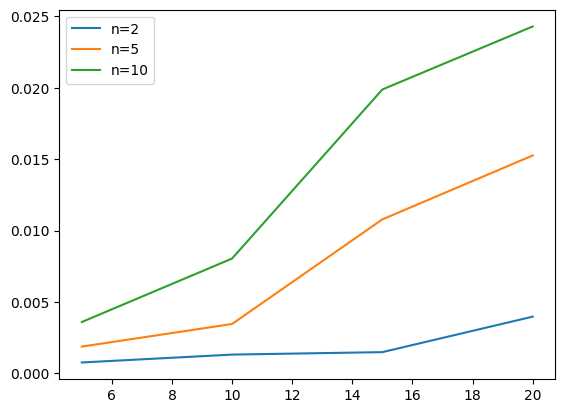

In [125]:
import matplotlib.pyplot as plt

data=[i[2]for i in res]
p=[5,10,15,20]
c1=[] 
c2=[] 
c3=[]
for i in range (len(data)):
    if i>=0 and i<4:
        c1+=[data[i]]
    elif i>=4 and i<8:
        c2+=[data[i]]
    else:
        c3+=[data[i]]

plt.plot(p,c1, label='n=2')
plt.plot(p,c2,label='n=5')
plt.plot(p,c3,label='n=10')
plt.legend()
